# Trabajo Práctico 2: SVM

El objetivo del algoritmo SVM es encontrar un hiperplano que separe de la mejor forma posible dos clases diferentes de puntos de datos. “De la mejor forma posible” implica el hiperplano con el margen más amplio entre las dos clases. Para encontrar el mejor modelo se buscaran los siguientes hiperparametros.

+ C --> Parámetro de regularización. La fuerza de la regularización es inversamente proporcional a C.
+ kernel --> Define el producto con el que se busca el mejor hiperplano. Gracias a esto el modelo simula estar en una dimension superior, en caso de no ser linealmente separables en la dimension original.
+ degree --> Grado de la función del kernel polinomial ('poli'). Ignorado por todos los demás kernels.
+ gamma --> Parametro utilizando para el kernel RBF.
+ class_weight --> El importancia que tiene los ceros o unos.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from sklearn.svm import SVC
from sklearn import svm

from preprocesamiento import feature_engineering
from preprocesamiento import obtenerDFHoldout, obtenerDFTraining
from preprocesamiento import preprocesar_data_frame

from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

RANDOM_STATE = 19 * 103785

## Funciones de Preprocesamiento

In [3]:
from preprocesamiento import metricas
from preprocesamiento import prepros_dummies
from preprocesamiento import preprocesar_variables_numericas

### Busqueda de hiperparametros: Kernel POLY

Para la busqueda de hiperparametros decidimos separarlo por los distintos kernels incialmente buscaremos con el kernel polinomial

In [3]:
df = obtenerDFTraining()
(X,y) = preprocesar_data_frame(df)
X_prepos = prepros_dummies(X[['ganancia_perdida_declarada_bolsa_argentina','trabajo',
                                      'estado_marital','genero',"anios_estudiados"]])
X_prepos = preprocesar_variables_numericas(X_prepos)

x_train, x_test, y_train, y_test = train_test_split(X_prepos, y, test_size=0.25, random_state=RANDOM_STATE)

Inicialemte probaremos con el kernel Poly y con un preprocesamiento donde selecionamos las variables mas importante (por lo visto en el parte 1) y aplicamos la funcion tanh a el feature ganancia para reducir su varianza.

In [4]:
parametros_poly = {'kernel' : ['poly'],'C':range(0,250,50),'degree':range(2,6),
                   'class_weight' :  [{0: 1,1: 1},{0: 1,1: 1.25},{0: 1,1: 1.5},{0: 1,1: 2}],
                   'random_state':[RANDOM_STATE]}

svc = svm.SVC()
clf_kernel_poly = GridSearchCV(svc, parametros_poly,n_jobs =-1,verbose = 4, scoring = 'roc_auc')

clf_kernel_poly.fit(x_train, y_train)

print(classification_report(y_test,clf_kernel_poly.predict(x_test)))
clf_kernel_poly.best_params_

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 206 tasks      | elapsed: 49.5min
[Parallel(n_jobs=-1)]: Done 329 tasks      | elapsed: 140.7min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 240.2min finished


              precision    recall  f1-score   support

           0       0.88      0.89      0.88      6196
           1       0.63      0.61      0.62      1936

    accuracy                           0.82      8132
   macro avg       0.76      0.75      0.75      8132
weighted avg       0.82      0.82      0.82      8132



{'C': 200,
 'class_weight': {0: 1, 1: 1.25},
 'degree': 2,
 'kernel': 'poly',
 'random_state': 1971915}

Probamos el mejor modelo por separado y corremos las metricas.

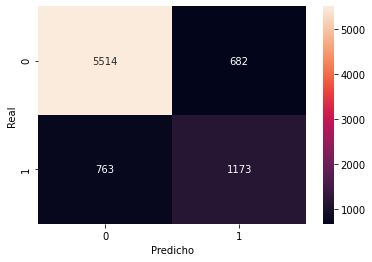

Recall: 0.61
Precision: 0.63
Acc: 0.82
Roc: 0.88


In [4]:
df = obtenerDFTraining()
(X,y) = preprocesar_data_frame(df)
X_prepos = prepros_dummies(X[['ganancia_perdida_declarada_bolsa_argentina','trabajo',
                              'estado_marital','genero',"anios_estudiados"]])
X_prepos = preprocesar_variables_numericas(X_prepos)

x_train, x_test, y_train, y_test = train_test_split(X_prepos, y, test_size=0.25, random_state=RANDOM_STATE)

svm_poly = svm.SVC(C = 200,class_weight= {0: 1, 1: 1.25},degree = 2,kernel= 'poly',probability=True,random_state =RANDOM_STATE)

svm_poly.fit(x_train, y_train)

metricas(y_test,svm_poly.predict(x_test),x_test,svm_poly)

### Busqueda de hiperparametros: Kernel RBF

Ahora probaremos con otro kernel. En este caso utilizaremos el Kernel radial, ademas de utilizar un preprocesamiento disntinto utilizando PCA

In [6]:
from preprocesamiento import preprocesar_df_min_max_scaler
from preprocesamiento import preprocesar_df_pca

df = obtenerDFTraining()
X, y = preprocesar_data_frame(df)
X = preprocesar_df_min_max_scaler(X[['ganancia_perdida_declarada_bolsa_argentina','trabajo',
                                      'estado_marital','genero',"anios_estudiados"]])
X = preprocesar_df_pca(X,18)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

In [7]:
parametros_rbf = {'kernel' : ['rbf'],'C':range(100,501,50),
                  'class_weight' :  [{0: 1,1: 1},{0: 1,1: 1.25},{0: 1,1: 1.5},{0: 1,1: 2}],
                  'gamma' :['scale','auto'], 'random_state':[RANDOM_STATE]}

svc = svm.SVC()
clf_kernel_rbf = GridSearchCV(svc, parametros_rbf,n_jobs =-1,verbose = 4,scoring = 'roc_auc')

clf_kernel_rbf.fit(x_train, y_train)

print(classification_report(y_test,clf_kernel_rbf.predict(x_test)))
clf_kernel_rbf.best_params_

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed: 67.9min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 125.8min finished


              precision    recall  f1-score   support

           0       0.89      0.84      0.87      6196
           1       0.57      0.68      0.62      1936

    accuracy                           0.80      8132
   macro avg       0.73      0.76      0.74      8132
weighted avg       0.82      0.80      0.81      8132



{'C': 500,
 'class_weight': {0: 1, 1: 2},
 'gamma': 'auto',
 'kernel': 'rbf',
 'random_state': 1971915}

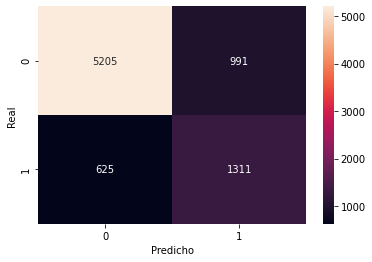

Recall: 0.68
Precision: 0.57
Acc: 0.8
Roc: 0.85


In [10]:
df = obtenerDFTraining()
X, y = preprocesar_data_frame(df)
X = preprocesar_df_min_max_scaler(X[['ganancia_perdida_declarada_bolsa_argentina','trabajo',
                                      'estado_marital','genero',"anios_estudiados"]])
X = preprocesar_df_pca(X,18)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)


svm = SVC(kernel='rbf', C=500,gamma = 'auto',probability=True,class_weight= {0: 1, 1: 2}, random_state=1971915)

svm.fit(x_train, y_train)

metricas(y_test,svm.predict(x_test),x_test,svm)

Luego de todo este analisis decidimos quedarnos con el primero ya que en general tiene mejores metricas

Preprocesamiento:

+ Seleccion de variables 
+ One hot encoding
+ tanh para gananciaen bolsa


Hiperparametros:

+ C --> 200
+ class_weight --> {0: 1, 1: 1.25}
+ degree--> 2
+ kernel --> 'poly'

### Prediccion sobre el Holdout

In [6]:
from preprocesamiento import escribir_predicciones_a_archivo

holdout = obtenerDFHoldout()

ids = np.array(holdout['id'])

holdout = prepros_dummies(holdout[['ganancia_perdida_declarada_bolsa_argentina','trabajo',
                                      'estado_marital','genero',"anios_estudiados"]])
holdout = preprocesar_variables_numericas(holdout)

predicciones_holdout = svm_poly.predict(holdout)
escribir_predicciones_a_archivo(predicciones_holdout,"SVM",ids)